In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from scipy.optimize import curve_fit as fit
from scipy.interpolate import interp1d
import pandas as pd

import sys
import os
 
%matplotlib inline

In [2]:
# constants
h = 6.626e-34 # plancks constant, J/s
c = 2.99792458e8 # m/s
k = 1.381e-23 # boltzmann's constant, J/K

In [3]:
# parameters

# X-rays
photon_energy_keV = 10 # keV
photon_energy = photon_energy_keV*1e3*1.602e-19 # J
wavelength = h*c / photon_energy # m
divergence = 1.2e-3 # divergence, rad

# end-station
L = 4.0 # m 
pix = 55e-6*10 # m
d = 1e-3 # 1 mm sample thickness, m
beamstop = 4.8e-3 # beam stop
beam_size = np.array([88, 1200, 2400])*1e-9
w0 = 88e-9/2        # half beam waist, m
distance = np.array([0, 1000e-6, 2000e-6]) # m

# coherence 
bandwidth = 1e-4 

## Scattering volume

Text(0, 0.5, 'scattering volume (fL)')

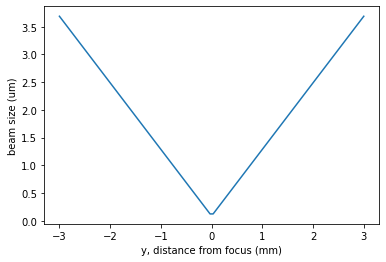

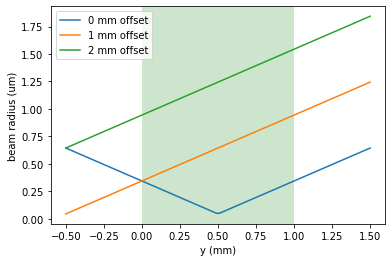

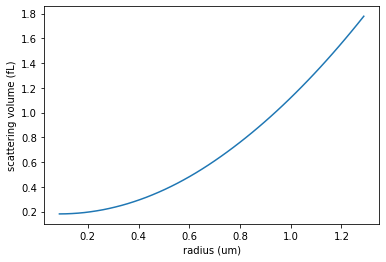

In [15]:
def beam_radius(distance, w0, divergence):
    " Beam radius for different sample positions (distances from the focal plane). "
    radius = w0 + np.abs(distance) * np.tan(divergence/2) 
    return radius

def beam_radius2(y, offset, w0, divergence, d): 
    " Beam radius for shifting beam focus position and fixed sample position. "
    return w0 + np.abs(y-d/2+offset) * np.tan(divergence/2) 

dist = np.linspace(-3000e-6,3000e-6,100)
plt.figure()
plt.plot(dist*1e3, 2*beam_radius(dist, w0, divergence)*1e6)
plt.ylabel('beam size (um)')
plt.xlabel('y, distance from focus (mm)')

def volume_element(distance, w0, divergence, dz):
    radius = beam_radius(dist, w0, divergence)
    volume = np.abs(radius)**2 * dz
    return volume

def area_element(distance, w0, divergence):
    " Transverse area element of a divergent beam with focus radius w0. "
    radius = beam_radius(np.abs(distance), w0, divergence)
    area = np.abs(radius)**2 
    return area
    
dist = np.linspace(-500e-6,1500e-6,100)
plt.figure()
plt.plot(dist*1e3, beam_radius2(dist, 0, w0, divergence, d)*1e6, label='0 mm offset')
plt.plot(dist*1e3, beam_radius2(dist, 1e-3, w0, divergence, d)*1e6, label='1 mm offset')
plt.plot(dist*1e3, beam_radius2(dist, 2e-3, w0, divergence, d)*1e6, label='2 mm offset')
plt.axvspan(0, d*1e3, facecolor='g', alpha=0.2)
plt.ylabel('beam radius (um)')
plt.xlabel('y (mm)')
plt.legend()

def scattering_volume(offset):
    " Scattering volume for different sample offsets from the focus. "
    volume = np.empty((len(offset),))
    for i in range(len(offset)):
        M2 = lambda y: (2*beam_radius2(y, offset[i], w0, divergence, d))**2
        V = integrate.quad(M2, 0, d) # scattering volume
        volume[i] = V[0]
    return volume

offset = np.linspace(0,1,50)*1e-3 # m
a = 2*beam_radius(offset, w0, divergence) 
plt.figure()
plt.plot(a*1e6, scattering_volume(offset)*1e15, label='0')
plt.xlabel('radius (um)')
plt.ylabel('scattering volume (fL)')

# Contrast estimations

### Experimental contrast values

In [5]:
Q_w, beta_w, beta_err_w = np.load('beta_data_water_simple_exp.npy')
Q_dmso, beta_dmso, beta_err_dmso = np.load('beta_data_dmso_simple_exp.npy')

(9, 3) (9, 3)


### Contrast functions

In [8]:
from scipy import integrate
import math

q = np.linspace(6e-2, 12e-2, 100) # 1/nm
q = q*1e9 # 1/m

def beta_cl(a, d, bandwidth, wavelength, qval):
    " Contrast reduction due to finite coherence lengths. " 
    k = 2*np.pi/wavelength
    etah = 12.90e-6 # m, horizontal coherence length based on the focused nanobeam divergence
    etav = 7.66e-6  # m, vertical coherence length based on the focused nanobeam divergence
    A = bandwidth * qval * np.sqrt(1 - 0.25 * qval**2 / k**2)
    B = - bandwidth/2 * qval**2 / k
    
    B_r = lambda x, y: 2/(a*d)**2 * (a-x) * (d-y) * np.exp(-x**2/etah**2) * ( np.exp(-2*np.abs(A*x+B*y)) + np.exp(-2*np.abs(A*x-B*y)) )
    out_Br = integrate.dblquad(B_r, 0, d, lambda x: 0, lambda y: a)
    
    B_z = lambda z: 2/a**2 * (a-z) * np.exp(-z**2/etav**2)
    out_Bz = integrate.quad(B_z, 0, a)
    
    return  out_Br[0] * out_Bz[0]

def beta_res(a, L, pix, wavelength):
    " Contrast reduction due to finite angular resolution. "
    w = 2*np.pi*pix*a/(L*wavelength)
    f2 = lambda v: 2/w**2 * (w-v) * (np.sin(v/2)/(v/2))**2
    out = integrate.quad(f2, 0, w)
    return np.array(out[0]**2)

def speckle_contrast(a, d, L, pix, wavelength, bandwidth, qval):
    " Total speckle contrast. " 
    beta = beta_res(a, L, pix, wavelength) * beta_cl(a, d, bandwidth, wavelength, qval) 
    return beta

def nom(distance, w0, divergence, d, L, pix, wavelength, bandwidth, qval): 
    " Nominator for weighted averaging of the contrast for beam sizes along the optical path through the sample. "
    width = 2*beam_radius(distance, w0, divergence)
    area = area_element(distance, w0, divergence)
    contrast = speckle_contrast(width, d, L, pix, wavelength, bandwidth, qval) 
    nom = contrast*area 
    return nom

def int_contrast(offset, w0, divergence, d, L, pix, wavelength, bandwidth, qval):
    " Calculate the weighted average over beam sizes along the sample optical path. "
    y_nom, err_nom = integrate.quad(nom, -d/2+offset, d/2+offset, args=(w0, divergence, d, L, pix, wavelength, bandwidth, qval))
    y_den, err_den = integrate.quad(area_element, -d/2+offset, d/2+offset, args=(w0, divergence,))
    return y_nom/y_den 


### Contrast vs q

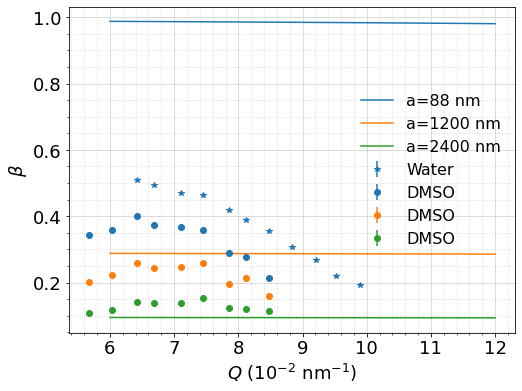

In [10]:
plt.figure(figsize=(8,6))
i=0
offsets = np.array([0, 1000e-6, 2000e-6])

for a in beam_size:
    
    contrast = np.empty((len(q),))
    for j in range(len(q)):
        contrast[j] = speckle_contrast(a, d, L, pix, wavelength, bandwidth, q[j])    
    l, = plt.plot(q*1e-9*1e2, contrast, label=r'a=%.d nm' %(np.round(a*1e9)))
    
    if i==0:
        plt.errorbar(Q_w*1e2,beta_w,yerr=beta_err_w, fmt='*', color=l.get_color(), label='Water')
        plt.errorbar(Q_dmso[:,i]*1e2,beta_dmso[:,i],yerr=beta_err_dmso[:,i], fmt='o', color=l.get_color(), label='DMSO')
    else:
        plt.errorbar(Q_dmso[:,i]*1e2,beta_dmso[:,i],yerr=beta_err_dmso[:,i], fmt='o', color=l.get_color(), label='DMSO')
    
    i += 1
    
plt.tick_params(labelsize=18)
plt.xlabel(r'$Q$ (10$^{-2}$ nm$^{-1}$)', size=18)
plt.ylabel(r'$\beta$', size=18)
plt.minorticks_on()
plt.grid(which='major',color='lightgrey')
plt.grid(which='minor',linestyle=':', color='lightgrey')
#plt.xscale('log')
#plt.yscale('log')
plt.legend(frameon=False, fontsize=16)

plt.show()

### Contrast vs beam size

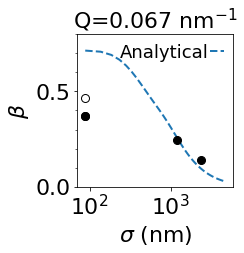

In [11]:
fig, axs = plt.subplots(1, 1, figsize=(2.8,2.8))

for j in [3]: 

    q = Q_dmso[j,0]
    offset = np.linspace(0,4,100)*1e-3
    a = 2*beam_radius(offset, w0, divergence)

    #contrast = np.empty((len(a),))
    #for i in range(len(a)):
    #    contrast[i] = speckle_contrast(a[i], d, L, pix, wavelength, bandwidth, q)   
    #l, = plt.plot(a*1e9, contrast, '-', lw=2, label='Analytical without averaging')
        
    contrast = np.empty((len(offset),))
    for i in range(len(offset)):
        contrast[i] = int_contrast(offset[i], w0, divergence, d, L, pix, wavelength, bandwidth, q) # weighted average       
    l, = plt.plot(a*1e9, contrast, '--', lw=2, label='Analytical')

    plt.plot(beam_size[0]*1e9,beta_w[j], 'o', markerfacecolor='none', color='k', ms=8) #, label='Water')
    plt.plot(beam_size[0]*1e9,beta_dmso[j,0], 'o', color='k', ms=8) #, label='DMSO')
    for i in range(len(beam_size)):
        plt.plot(beam_size[i]*1e9,beta_dmso[j,i], 'o', ms=8, color='k')

plt.tick_params(labelsize=22)
plt.xlabel(r'$\sigma$ (nm)', size=22)
plt.ylabel(r'$\beta$', size=22)
plt.minorticks_on()
#plt.grid(which='major',color='lightgrey')
#plt.grid(which='minor',linestyle=':', color='lightgrey')
plt.xscale('log')
#plt.yscale('log')
plt.legend(frameon=False, loc='upper right', fontsize=18, handletextpad=0.1, borderpad=0., handlelength=0.8, labelspacing=0.1, markerfirst=False)
axs.set_xticks([1e2,1e3])
plt.ylim([0,0.8])
plt.xlim([7e1,6e3])
plt.title('Q=%.3f nm$^{-1}$' %(q), size=22)

#plt.savefig('contrast_analysis.png', dpi=300, bbox_inches='tight',) # save plot

plt.show()